# Compare SBPS to pSBPS - logistic regression

### Import libraries

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
import numpy as np
from samplers import *
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import linear_model
import copy
import scipy.stats
import itertools
import os
import time
sess = tf.compat.v1.InteractiveSession()
tf.compat.v1.disable_eager_execution()

2023-12-03 20:48:55.849894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


### Data generation

In [2]:
# Generate logistic regression data
D =   20
N = 1000
target_w = 10*(np.random.rand(D) - .5)
train_images = np.random.rand(N,D) - .5
cov = np.diag(np.ones(D))
cov[0,0] = 1/float(500)
#cov = np.linalg
for i in range(N):
    train_images[i,:] = np.random.multivariate_normal(np.zeros(D),cov)
base=np.float64
tfbase=tf.float64
train_probs = logit(np.dot(train_images,target_w))
train_labels = np.expand_dims(train_probs<np.random.rand(N),1).astype(base)
data = np.float64( train_images.reshape( train_labels.shape[0], train_images[0].size ) )
labels = train_labels
probs=logit(np.matmul(train_images, target_w))
def test_error():
    return 0

In [3]:
# Use SKLearn to run SAG
import sklearn.linear_model as lin_mod
skLogistic=lin_mod.LogisticRegression(fit_intercept=False,solver='sag',C=1e10,max_iter=N*10,tol=1e-6)
skLogistic.fit(data,np.reshape(labels,[N,]))
W_map=skLogistic.coef_.copy()
probs_sk=logit(np.matmul(train_images, np.reshape(W_map,[D,1])))
print(W_map-target_w) # show differences in W
W_map = np.transpose(W_map)
W_map = np.squeeze(W_map)

[[-0.79837755 -0.10210419 -0.15692887  0.02388174  0.04541383  0.02447948
   0.02583089  0.02829573 -0.09798444 -0.19465376 -0.12514626 -0.01877565
  -0.20436867  0.14508538 -0.13229052  0.28889192 -0.01287721 -0.0719918
  -0.12300726  0.12415859]]


### Model Statement

In [7]:
xPH = tf.compat.v1.placeholder(tfbase, [None,D])
yPH = tf.compat.v1.placeholder(tfbase, [None,1],)
W = tf.Variable(tf.zeros([D,1],tfbase),tfbase)
all_weights = [W]
w_shapes = [W.get_shape()]
linProd= tf.matmul(xPH,W)
objective=tf.nn.sigmoid_cross_entropy_with_logits(logits=linProd,labels=yPH)
NLL=tf.reduce_mean(objective)
# Create an ExponentialMovingAverage object

# operation to calculate gradient and return gradient
opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1)
grads_and_vars = opt.compute_gradients(NLL, all_weights)
gradients, variables = zip(*grads_and_vars)
weights = tf.reshape(variables[0],[D])
gPH = tf.compat.v1.placeholder(tfbase,[D])
grads_to_apply = []
grads_to_apply.append(tf.reshape(gPH,[D,1]))
grad_and_vars_to_apply=list(zip(grads_to_apply, variables))
tf_train_step = opt.apply_gradients(grad_and_vars_to_apply)

vPH=tf.compat.v1.placeholder(tfbase,[D])
yPred=tf.sigmoid(linProd)
xPHR=tf.reshape(xPH,[-1,D])
gradient_explicit=-(yPH-yPred)*xPHR
tf_grad_calc=tf.reduce_mean(gradient_explicit,0)
gradient_variance_calculation=tf.reduce_mean(gradient_explicit*gradient_explicit,0) \
    -tf_grad_calc*tf_grad_calc
better_gradient_variance_intermediate=tf.matmul(gradient_explicit,tf.reshape(vPH,[D,1]))
tf_grad_var_calc=tf.nn.moments(better_gradient_variance_intermediate,[0])[1]
hessian_explicit= tf.reshape(yPred*(1-yPred),[-1,1,1])*(tf.reshape(xPHR,[-1,D,1])*tf.reshape(xPHR,[-1,1,D]))
hessian_calculation=tf.reduce_mean(hessian_explicit,0)

correct_prediction = tf.equal(yPH, tf.cast(.5+.5*tf.sign(tf.matmul(xPH, W)),tfbase))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tfbase))

# wrapping tf functions to pass to run_sampler and generate_sbps_samples
def grad_calc(data,labels):
    return tf_grad_calc.eval(feed_dict={xPH: data, yPH: labels})
def grad_var_calc(data,labels,v):
    return tf_grad_var_calc.eval(feed_dict={xPH: data, yPH: labels, vPH: v})
def train_step(g):
    return tf_train_step.run(feed_dict={gPH: g})
weights = flatten_tensor_list(all_weights)
def get_weights():
    return weights.eval()
# function to assign weights
assign_weights_ops = []
curr_ind = 0
w_to_assign = tf.compat.v1.placeholder(tfbase,[D],name='w_to_assign')
for [weight,shape] in zip(all_weights,w_shapes):
    assign_weights_ops.append(weight.assign(tf.reshape(w_to_assign[curr_ind:curr_ind + int(np.prod(shape))],shape)))
    curr_ind += int(np.prod(shape))
def set_weights(w):
    for a_w in assign_weights_ops:
        sess.run(a_w,feed_dict={w_to_assign:w})

### function to initialize session and run optimization/sampling

In [5]:
# Calculate Hessian
sess.run(tf.compat.v1.global_variables_initializer())
set_weights(W_map)
hessian_map=hessian_calculation.eval(feed_dict={xPH: data, yPH: labels})
hessian_map=hessian_map*N
cov_map=np.linalg.inv(hessian_map)
cond_num = np.max(np.linalg.eig(hessian_map)[0])/float(np.min(np.linalg.eig(hessian_map)[0]))
print ('condition number ', cond_num)

condition number  1005.3618936878329


## Run samplers

In [20]:
# run samplers
n_epochs=1000
batch_size=100
total_iter=n_epochs*(N/batch_size)
NLL_factor = total_iter
print('Running ' + str(n_epochs) + ' epochs (' +str(total_iter) + ' iterations) per method')
fW_map = np.ndarray.flatten(W_map)

W_start = np.random.multivariate_normal(fW_map,cov_map*100)
k = 3
plt_labels = []
trajectories = []
NLLs = []

# SBPS
k = 3
print('Running SBPS, k = ' + str(k))
sess.run(tf.compat.v1.initialize_all_variables())
my_SBPS = SBPS(D,N,batch_size,k)
NLL_SBPS_0,samples_SBPS_0 = run_sampler(my_SBPS,get_weights,set_weights,\
                                                       test_error,total_iter,n_epochs,NLL_factor,\
                                                       data,labels,batch_size,grad_calc,\
                                                       train_step,grad_var_calc,W_init=W_start)
NLL_SBPS,samples_SBPS = generate_SBPS_samples(my_SBPS,get_weights,set_weights,test_error,\
                                                train_step,NLL_factor,W_init=W_start)


#NLL_SBPS_0,acc_SBPS,samples_SBPS_0 = runOptimizationExplicit(my_SBPS,0,W_start)
#NLL_SBPS,samples_SBPS = generate_SBPS_samples(my_SBPS,W_start,W,N)
my_SBPS.print_summary()
plt_labels.append('SBPS')
trajectories.append(samples_SBPS)
NLLs.append(NLL_SBPS)

# pSBPS
print('Running pSBPS, k = ' + str(k))
sess.run(tf.compat.v1.initialize_all_variables())
my_pSBPS = SBPS(D,N,batch_size,k)
NLL_pSBPS_0,samples_pSBPS_0 = run_sampler(my_pSBPS,get_weights,set_weights,\
                                                       test_error,total_iter,n_epochs,NLL_factor,\
                                                       data,labels,batch_size,grad_calc,\
                                                       train_step,grad_var_calc,W_init=W_start,use_preconditioner=True)
NLL_pSBPS,samples_pSBPS = generate_SBPS_samples(my_pSBPS,get_weights,set_weights,test_error,\
                                                train_step,NLL_factor,W_init=W_start)
my_pSBPS.print_summary()
plt_labels.append('pSBPS')
trajectories.append(samples_pSBPS)
NLLs.append(NLL_pSBPS)

#assign_weights(W_map,all_weights,w_shapes) 
#NLL_map = sess.run(NLL, feed_dict={xPH: data, yPH: labels})
cond_num = np.max(np.linalg.eig(hessian_map)[0])/float(np.min(np.linalg.eig(hessian_map)[0]))
print('condition number ', cond_num)

Running 1000 epochs (10000.0 iterations) per method
Running SBPS, k = 3
Evaluating Test error / NLL -  0


2023-12-03 20:50:35.623013: W tensorflow/c/c_api.cc:300] Operation '{name:'Variable_1/Assign' id:176 op device:{requested: '', assigned: ''} def:{{{node Variable_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](Variable_1, zeros_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating Test error / NLL -  0
Time elapsed -  22.012594  secs ( 0.36687657  mins)
Warning - minibatch variance smaller than  1e-15  calculated  1  times. Consider increasing minibatch size.
Generating discrete samples from continuous SBPS trajectory
Evaluating Test error -  0
Number of bounces: 1425
percent p(acc)>1:  0.07929824561403509
percent rejections:  0.8575
percent negative slope:  0.1682
total travel time:  217.07019983797858
max trajectories:  0
refreshments: 13
Running pSBPS, k = 3
Evaluating Test error / NLL -  0


2023-12-03 20:51:03.039899: W tensorflow/c/c_api.cc:300] Operation '{name:'Variable_1/Assign' id:176 op device:{requested: '', assigned: ''} def:{{{node Variable_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](Variable_1, zeros_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Evaluating Test error / NLL -  0
Time elapsed -  24.283445  secs ( 0.4047241  mins)
Warning - minibatch variance smaller than  1e-15  calculated  1  times. Consider increasing minibatch size.
Generating discrete samples from continuous SBPS trajectory
Evaluating Test error -  0
Number of bounces: 1098
percent p(acc)>1:  0.061930783242258654
percent rejections:  0.8902
percent negative slope:  0.2002
total travel time:  375.0688052103604
max trajectories:  0
refreshments: 21
condition number  1005.3618936878329


## Plots

In [9]:
# make plots pretty
plt.rcParams['font.size'] = 16
plt.rcParams['font.family']='serif'
plt.rcParams['mathtext.default']='regular'

def plot_traj():
    # Trajectories 
    def gauss(x,y,hess,mu):
        vec = np.asarray([x,y]) - np.asarray(mu)
        return  -np.dot(vec,np.dot(hess,np.transpose(vec)))/2.0
    cont_range = 50
    x = np.linspace(W_map[0]-cont_range*np.sqrt(cov_map[0,0]), W_map[0]+cont_range*np.sqrt(cov_map[0,0]), 100)
    y = np.linspace(W_map[1]-cont_range*np.sqrt(cov_map[1,1]), W_map[1]+cont_range*np.sqrt(cov_map[1,1]), 100)
    X, Y = np.meshgrid(x, y)
    zs = np.array([gauss(x,y,np.linalg.inv(cov_map[0:2,0:2]),[W_map[0],W_map[1]]) \
                   for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    CL = plt.contour(X, Y, Z,np.arange(-50, -1, 10),label='Laplace approx.',colors=('k'))
    plt.clabel(CL, inline=1, fontsize=10)

    # plt.title('Trajectories')
    ptx = []
    pty = []
    for i in range(10):
        tx = np.random.multivariate_normal(np.ndarray.flatten(W_map),cov_map)
        ptx.append(tx[0])
        pty.append(tx[1])


    for i in range(len(trajectories)):
        plt.plot(trajectories[i][:-1,0],trajectories[i][:-1,1],label=plt_labels[i])
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')

In [10]:
def rotate_traj_ACF(trajectories,burnin):
    base_change = np.linalg.eig(cov_map)[1]
    corr2s = []
    inds = [np.linalg.eig(cov_map)[0].argmax(),np.linalg.eig(cov_map)[0].argmin()]
    wtrajectories = []
    for i in range(len(trajectories)):
        wtrajectories.append(np.dot(trajectories[i],base_change))
    wwmap = np.squeeze(np.dot(np.transpose(W_map),base_change))
    for j in range(2):
        corrs3 = [] 
        for i in range(len(trajectories)): 
            #ACF
            sig = wtrajectories[i][burnin:,inds[j]] - np.mean(wtrajectories[i][burnin:,inds[j]]) 
            corr = np.correlate(sig,sig,'full') 
            corr = corr/np.max(corr)
            corr = corr[int(corr.shape[0]/2):] 
            corrs3.append(corr)
        corr2s.append(corrs3)
    return wtrajectories, corr2s, wwmap
#[wtrajectories, corr2s, wwmap] = rotate_traj_ACF(trajectories,burnin)

In [11]:
def all_plots2(NLLs,plt_labels,fname,corr2s,wtrajectories,wwmap,mbs):
    plt.rcParams['font.size'] = 13
    plt.rcParams['font.family']='serif'
    plt.rcParams['mathtext.default']='regular'
    inds = [np.linalg.eig(cov_map)[0].argmax(),np.linalg.eig(cov_map)[0].argmin()]
    
    # NLL plot
    from matplotlib.ticker import FormatStrFormatter,AutoMinorLocator
    plt.subplots(figsize=(9,3))

    # ACF
    total_iter = max([len(wtrajectories[i])*mbs[i] for i in range(len(wtrajectories))])
    j = 1
    plt.subplot(132)
    #plt.title('direction of largest covariance')
    for i in range(len(wtrajectories)): 
        x = np.asarray(range(len(corr2s[0][i])))
        plt.semilogx(mbs[i]*x,corr2s[0][i],label=plt_labels[i]) 
    plt.xlabel('lag')    
    plt.ylabel('ACF (largest variance)')
    plt.grid()
    plt.axis([0,total_iter-burnin,np.min([min(c) for c in corr2s[0]]),1])

    #2d traj
    plt.subplot(131)
    plot_traj()
    plt.axis([-50,50,-8,1])
    plt.legend(prop={'size':12})
    
    def plot_coord(j):
        rng = 2*total_iter/5
        std = np.sqrt(np.linalg.eig(cov_map)[0])[inds[j]]
        for i in range(len(wtrajectories)): 
            x = np.asarray(range(len(wtrajectories[i][:int(rng/mbs[i]),:])))
            plt.plot(mbs[i]*x,wtrajectories[i][:int(rng/mbs[i]),inds[j]])
        plt.plot([0,rng],[wwmap[inds[j]],wwmap[inds[j]]],color='black',lw=2)
        plt.plot([0,rng],[wwmap[inds[j]] + std,wwmap[inds[j]] + std],color='black',linestyle='--',lw=2)
        plt.plot([0,rng],[wwmap[inds[j]] - std,wwmap[inds[j]] - std],color='black',linestyle='--',lw=2)
        plt.xlabel('data points observed') 
        plt.locator_params(axis='x',nbins=2)
    # Coordinates (largest)
    plt.subplot(133)
    plot_coord(0)
    plt.ylabel('coordinate trace')

    plt.tight_layout()

In [23]:
# generate and save plots
burnin = 1000
[wtrajectories, corr2s, wwmap] = rotate_traj_ACF(trajectories,burnin)

/var/folders/mc/mjz6jzk55kvc_8bhz7vcv5_m00k0w7/T/ipykernel_76174/2347924279.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0,total_iter-burnin,np.min([min(c) for c in corr2s[0]]),1])
/var/folders/mc/mjz6jzk55kvc_8bhz7vcv5_m00k0w7/T/ipykernel_76174/2216915723.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  CL = plt.contour(X, Y, Z,np.arange(-50, -1, 10),label='Laplace approx.',colors=('k'))


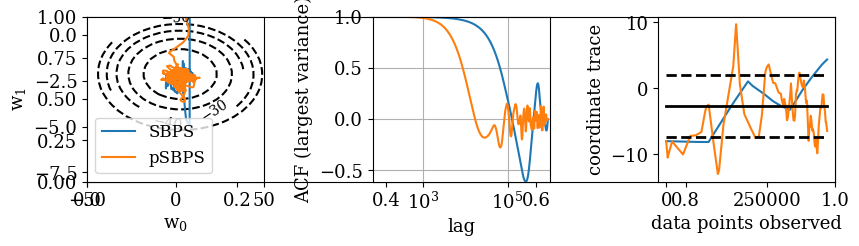

In [24]:
all_plots2(NLLs,plt_labels,'prec2',corr2s,wtrajectories,wwmap,[batch_size]*len(NLLs))